## Importar Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler
from sklearn.model_selection import train_test_split

## Primera mirada

In [2]:
df = pd.read_csv('train.csv')
#df = pd.read_csv('train_original.csv')

In [3]:
df.shape

(1696, 8)

In [4]:
df.isna().sum()

Image_path            0
Insurance_company     0
Cost_of_vehicle      95
Min_coverage         95
Expiry_date           0
Max_coverage         95
Condition             0
Amount               11
dtype: int64

Notar que en este caso:
- ```Image path``` : Contiene el path al archivo
- ```Insurance_company``` : Nombre de la compañía de seguros involucrada
- ```Cost_of_vehicle``` : Costo inicial del vehículo involucrado, en USD 
- ```Min_coverage``` : Monto de la cobertura mínima
- ```Max_coverage```: Monto de la cobertura máxima
- ```Expiry_date```: Fecha de expiración de la cobertura           
- ```Condition```: 0 si el auto está sin daños, 1 si está dañado 

Como criterio conservador, simplemente voy a omitir de la muestra los datos faltantes

In [5]:
df.dropna(inplace =True)

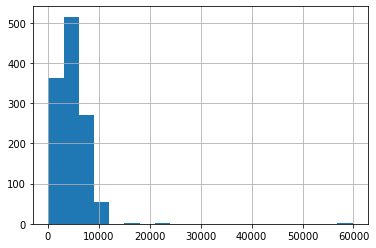

In [6]:
df[df.Amount!=0]['Amount'].hist(bins =20);

Lo primero que voy a hacer es expresar el daño en términos relativos al costo original del vehículo
¿Hay daños mayores que el valor inicial del vehículo?

In [7]:
df[df['Amount']>df['Cost_of_vehicle']]

,Image_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,Condition,Amount
1613,img_7767995.jpg,AA,32500.0,812.5,2022-03-03,8203.0,1,59844.0


De modo que debo filtrar:

In [8]:
df = df[(df['Amount']<=df['Cost_of_vehicle'])]

In [9]:
df['relative_amount'] = df['Amount']/df['Cost_of_vehicle']

In [10]:
len(df)

1591

Se nota asimetría de los montos relativos, hacia daños bajos

Por el momento, vamos a trabajar solo con los datos que tenemos OK

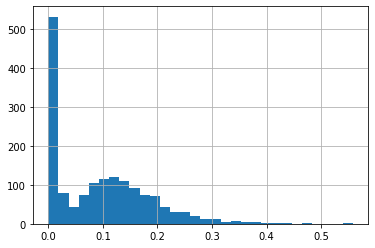

In [11]:
df.relative_amount.hist(bins=30)

Voy a separar, momentáneamente, vehículos dañados de los que no lo están

In [12]:
df_sin_danno = df[df['Amount']==0]
df_con_danno = df[df['Amount']!=0]

In [13]:
df_sin_danno = df_sin_danno.assign(severidad='indemne')

In [14]:
df_con_danno = df_con_danno.assign(severidad=pd.qcut(df_con_danno.relative_amount,
                                                     q=[0.0,0.35,0.7,1],
                                                     labels=['leve','media','severa']))

In [15]:
df_con_danno.severidad.value_counts()

media     421
leve      421
severa    361
Name: severidad, dtype: int64

In [16]:
len(df[df.Amount==0])

388

In [17]:
df = pd.concat([df_con_danno,df_sin_danno],axis=0) 

In [18]:
df.severidad.value_counts()

media      421
leve       421
indemne    388
severa     361
Name: severidad, dtype: int64

In [19]:
len(df)

1591

A su vez, respecto de los montos de cobertura máxima y mínima, parece razonable expresar en términos relativos

In [20]:
df['p_min_cov'] = df['Min_coverage']/df['Cost_of_vehicle']
df['p_max_cov'] = df['Max_coverage']/df['Cost_of_vehicle']

In [21]:
df['Insurance_company'].value_counts().sort_index()

A     159
AA    148
AC    128
B     163
BB    147
BC    145
BQ    158
C     148
DA    136
O     142
RE    117
Name: Insurance_company, dtype: int64

En una primera versión del modelo, codificaremos la compañía de seguros

In [22]:
ins_cos=pd.get_dummies(df['Insurance_company'],prefix='Co')

In [23]:
df = pd.concat([df,ins_cos],axis=1)

A su vez, vamos a encontrar los días restantes que el vehículo está bajo cobertura

In [24]:
HOY = pd.to_datetime(datetime.date(2021,6,30))

In [25]:
df['Expiry_date']=pd.to_datetime(df['Expiry_date'])

In [26]:
df['dias_pendientes_cobertura']=(df['Expiry_date']-HOY).dt.days.astype(int)

Y vamos a escalar otras variables de interés

In [27]:
mms = MinMaxScaler()

In [28]:
df[['Cost_of_vehicle','dias_pendientes_cobertura']]=mms.fit_transform(df[['Cost_of_vehicle',
                                                                          'dias_pendientes_cobertura']])

In [29]:
df.columns

Index(['Image_path', 'Insurance_company', 'Cost_of_vehicle', 'Min_coverage',
       'Expiry_date', 'Max_coverage', 'Condition', 'Amount', 'relative_amount',
       'severidad', 'p_min_cov', 'p_max_cov', 'Co_A', 'Co_AA', 'Co_AC', 'Co_B',
       'Co_BB', 'Co_BC', 'Co_BQ', 'Co_C', 'Co_DA', 'Co_O', 'Co_RE',
       'dias_pendientes_cobertura'],
      dtype='object')

In [30]:
df.drop(columns = ['Insurance_company','Min_coverage','Max_coverage','Expiry_date','Condition',
                   'Amount','p_min_cov'],inplace=True)

Por último, elimino las columnas que no resultan de interés (notar que la cobertura mínima es fija).

In [31]:
df[df.relative_amount==df.relative_amount.max()]

,Image_path,Cost_of_vehicle,relative_amount,severidad,p_max_cov,Co_A,Co_AA,Co_AC,Co_B,Co_BB,Co_BC,Co_BQ,Co_C,Co_DA,Co_O,Co_RE,dias_pendientes_cobertura
1022,img_4635923.jpg,0.408019,0.557606,severa,0.252746,0,0,0,1,0,0,0,0,0,0,0,0.415933


In [32]:
df.iloc[-1,:]

Image_path                   img_7768625_90.jpg
Cost_of_vehicle                        0.323113
relative_amount                               0
severidad                               indemne
p_max_cov                              0.871519
Co_A                                          0
Co_AA                                         0
Co_AC                                         0
Co_B                                          0
Co_BB                                         0
Co_BC                                         0
Co_BQ                                         1
Co_C                                          0
Co_DA                                         0
Co_O                                          0
Co_RE                                         0
dias_pendientes_cobertura              0.639602
Name: 1665, dtype: object

In [33]:
len(df)

1591

In [34]:
X = df.iloc[:,1:].drop(columns=['severidad','relative_amount'])
y = df['relative_amount']

In [35]:
X.shape

(1591, 14)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    random_state=777)

In [37]:
from catboost import CatBoostRegressor

In [38]:
cb = CatBoostRegressor()

In [39]:
cb.fit(X_train,y_train,silent = True)

In [40]:
y_pred = cb.predict(X_test)

In [41]:
from sklearn.metrics import mean_squared_error,confusion_matrix

In [42]:
mean_squared_error(y_test,y_pred)

0.0053673850672292

(0, 0.5)

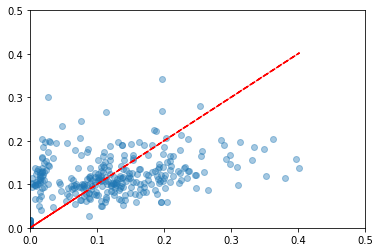

In [43]:
plt.scatter(y_test,y_pred,alpha=0.4)
plt.plot(y_test,y_test,color='red',linestyle='--')
plt.xlim(0,0.5)
plt.ylim(0,0.5)

In [44]:
y = df['severidad']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    random_state=777,
                                                    stratify=y)

In [46]:
from catboost import CatBoostClassifier

In [47]:
cbc = CatBoostClassifier()

In [48]:
cbc.fit(X_train,y_train,silent = True)

In [49]:
y_pred_c = cbc.predict(X_test)

In [50]:
y_test

1057     severa
249       media
578        leve
1168       leve
170     indemne
         ...   
1547      media
950        leve
124        leve
1578     severa
107       media
Name: severidad, Length: 398, dtype: object

In [51]:
confusion_matrix(y_test,y_pred_c)

array([[97,  0,  0,  0],
       [ 0, 47, 30, 28],
       [ 0, 41, 35, 30],
       [ 0, 27, 28, 35]])